In [1]:
from qoc import grape_schroedinger_discrete
from qoc.standard import TargetStateInfidelity

import autograd.numpy as anp
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix

%matplotlib inline
%reload_ext memory_profiler

In [2]:
# Define the system.
def get_memory_manually(N, l):
    """
    This function contains a simple example of grape
    on the schroedinger equation using time discrete
    control parameters to evolve a cavity from the
    Fock state 0 to the Fock state 1. Even though the
    system is not physical, it can be used to measure
    memory

    Args:
    N :: int - Numbers of time steps
    l :: int - Hilbert space dimension
    """

    HILBERT_SIZE = l
    diagnol=np.arange(HILBERT_SIZE)
    up_diagnol = np.sqrt(diagnol)
    low_diagnol = np.sqrt(np.arange(1, HILBERT_SIZE + 1))
    data = [low_diagnol, diagnol, up_diagnol]
    offsets = [-1, 0, 1]
    H_SYSTEM_0 = dia_matrix((data, offsets), shape=(HILBERT_SIZE, HILBERT_SIZE))
    sigmax = dia_matrix(([low_diagnol, up_diagnol], [-1, 1]),
                        shape=(HILBERT_SIZE, HILBERT_SIZE))

    # Only real control amplitudes are supported!
    hamiltonian = lambda controls, time: (H_SYSTEM_0
                                          + controls[0] * sigmax)

    # Define the problem.
    CAVITY_VACUUM = anp.zeros((l, 1))
    CAVITY_ZERO = anp.copy(CAVITY_VACUUM)
    CAVITY_ZERO[0, 0] = 1
    CAVITY_ONE = anp.copy(CAVITY_VACUUM)
    CAVITY_ONE[1, 0] = 1
    CAVITY_VACUUM = anp.zeros((l, 1))

    INITIAL_STATE_0 = anp.copy(CAVITY_VACUUM)
    INITIAL_STATE_0[0,0] = 1
    TARGET_STATE_0 = anp.copy(CAVITY_VACUUM)
    TARGET_STATE_0[1,0] = 1
    INITIAL_STATES = anp.stack((INITIAL_STATE_0,), axis=0)
    TARGET_STATES = anp.stack((TARGET_STATE_0,), axis=0)
    COSTS = [TargetStateInfidelity(TARGET_STATES)]

    # Define the optimization.
    COMPLEX_CONTROLS = False
    CONTROL_COUNT = 1
    EVOLUTION_TIME = 1e-6  # nanoseconds
    CONTROL_EVAL_COUNT = SYSTEM_EVAL_COUNT = N + 1
    ITERATION_COUNT = 1

    # Define output.
    LOG_ITERATION_STEP = 1
    CONTROL_HAMILTONIAN = [sigmax]

    MANUAL_PARAMETER = {"control_hamiltonian": CONTROL_HAMILTONIAN,
                        "manual_gradient_mode": True, "tol": 1e-6}

    result = grape_schroedinger_discrete(CONTROL_COUNT, CONTROL_EVAL_COUNT,
                                         COSTS, EVOLUTION_TIME, hamiltonian,
                                         INITIAL_STATES, SYSTEM_EVAL_COUNT,
                                         complex_controls=COMPLEX_CONTROLS,
                                         iteration_count=ITERATION_COUNT,
                                         log_iteration_step=LOG_ITERATION_STEP,
                                         manual_parameter=MANUAL_PARAMETER)

In [3]:
def memory_plot(h_dim, mem_mean):
    x = h_dim
    y = mem_mean

    plt.scatter(x, y, color='C0')
    plt.plot(x, y, color='C0', alpha = 0.5)

    plt.xscale("log")
    plt.xlabel("l")
    plt.ylabel("Memory usage [MiB]")

    plt.show()

In [4]:
# using memory_profiler
N_ = 1
#totol number of time step
mem_ma_Nfixed = []
#first is average value,second is standard deivation
h_dims = [int(10**i) for i in range(1, 5, 1)]
for dim in h_dims:
    mem_temp = %memit -r1 -i0.0001 -o get_memory_manually(N_, dim)
    mem_temp = np.array(mem_temp.mem_usage)

    mem_ma_Nfixed.append(np.average(mem_temp))

iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563492e-12
peak memory: 161.40 MiB, increment: 1.09 MiB
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563492e-12
peak memory: 162.98 MiB, increment: 1.56 MiB
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563492e-12
peak memory: 178.29 MiB, increment: 15.31 MiB
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563492e-12
peak memory: 394.73 MiB, increment: 216.43 MiB


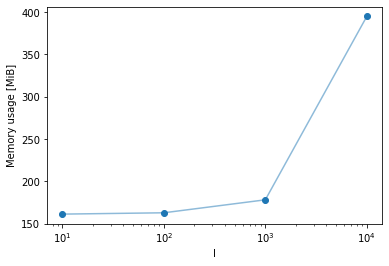

In [5]:
# plotting memory_profiler results
memory_plot(h_dims, mem_ma_Nfixed)